### API

In [ ]:
import requests
from datetime import date, datetime
from calendar import timegm

today = date.today()

base = "http://monipe-central.rnp.br"

def get_data(url_slice, time_range):
    url = base+url_slice
    header = {"time-range": time_range}
    response = requests.get(url, params=header)
    json_data = response.json()
    return json_data

def request_by_metadata_key(url, type):
    url_ = url
    response = requests.get(url_)
    json_data = response.json()
    if (response.status_code == 200):
        for obj in json_data["event-types"]:
            if obj["event-type"] == type:
                return obj
    else: 
        return response.status_code

def request(name, source, destination, type, time_range, target_bandwidth="9999999999"):
    url = "http://monipe-central.rnp.br/esmond/perfsonar/archive/?"
    hearder = {"pscheduler-test-type": type, "source": source, "destination": destination, "bw-target-bandwidth": target_bandwidth, "time-range": time_range}
    response = requests.get(url, params=hearder)
    json_data = response.json()
    if (response.status_code == 200):
        datas = []
        for obj in json_data:
            url_obj = obj["url"]
            get_url_base_obj = request_by_metadata_key(url_obj, type)
            if (not isinstance(get_url_base_obj, int)):
                url_base = get_url_base_obj["base-uri"]
                f = open(name+" esmond data "+today.strftime("%m-%d-%Y")+".csv", "w")
                f2 = open(name+" dados sem tratamendo "+today.strftime("%m-%d-%Y")+".csv", "w")
                data = get_data(url_base, time_range)
                datas.insert(0, data)
            else:
                return "Error " + response.status_code
        cont = 0
        soma = 0
        anterior = None
        teste = {}
        dados = []
        for i in range(len(datas)):
            dados += datas[i]
        for obj in dados:
            data = datetime.fromtimestamp(int(obj["ts"]))
            f2.write(datetime.fromtimestamp(int(obj["ts"])).strftime('%Y-%m-%d %H:%M:%S')+", "+str(obj["val"])+"\n")
            dia = str(data).split()[0][-2::]
            if str(data).split()[0][-5::] not in teste.keys():
                teste.setdefault(str(data).split()[0][-5::], 0)
            else:
                teste[str(data).split()[0][-5::]] += 1
            if dia == anterior or anterior is None:
                ultimo = obj["ts"]
                soma += obj["val"]
                cont += 1
                if cont > 6:
                    anterior = dia
                    ultimo = obj["ts"]
                    continue
                f.write(datetime.fromtimestamp(int(obj["ts"])).strftime('%Y-%m-%d %H:%M:%S')+", "+str(obj["val"])+"\n")
            else:
                media = soma/cont
                ciclos = 6-cont
                for i in range(ciclos):
                    cont += 1
                    f.write(datetime.fromtimestamp(int(ultimo)).strftime('%Y-%m-%d %H:%M:%S')+", "+str(media)+"\n")
                soma = 0
                soma += obj["val"]
                f.write(datetime.fromtimestamp(int(obj["ts"])).strftime('%Y-%m-%d %H:%M:%S')+", "+str(obj["val"])+"\n")
                cont = 1
            anterior = dia
            ultimo = obj["ts"]
        ciclos = 6-cont
        for i in range(ciclos):
            f.write(datetime.fromtimestamp(int(obj["ts"])).strftime('%Y-%m-%d %H:%M:%S')+", "+str(obj["val"])+"\n")
        f.close()
        f2.close()
        print(len(teste)*6)
        print(len(teste.keys())*6)
    else:
        return "Error: " + response.status_code
    
request("cubic", "monipe-ce-banda.rnp.br", "monipe-sp-banda.rnp.br", "throughput", "15552000") # 6 meses
request("bbr", "monipe-ce-banda.rnp.br", "monipe-sp-banda.rnp.br", "throughput", "15552000", "10000000000") # 6 meses

1014
1014
1020
1020


### LIB (R)

In [ ]:
# bibliotecas do python
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# bibliotecas do R
base = importr('base')
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
ts_analysis = ('urca','tseries','forecast','e1071','Metrics')

from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(ts_analysis))

(as ‘lib’ is unspecified)




















































































	‘/tmp/Rtmpn0cIa4/downloaded_packages’



<rpy2.rinterface_lib.sexp.NULLType object at 0x7f248b9f7c30> [RTYPES.NILSXP]

In [ ]:
# importando as bibliotecas do R usadas para predição
# acho que so precisa importar uma vez. (demora)

urca = importr('urca')
tseries = importr('tseries')
forecast = importr('forecast')
e1071 = importr('e1071')
metrics = importr('Metrics')

In [ ]:
# %R - "linha mágica" - retorna valor como objeto python

# %%R - "célula mágica" - nao retorna valor mas consegue passar input e output  

# Arguments
# -i  -  variaveis de input
# -o  -  variaveis de output
# -h  -  altura do plot
# -w  -  largura do plot


%load_ext rpy2.ipython

### Throughput Total (PRA - Remoção de Erros de Ciclo)

In [ ]:
TS = pd.read_csv(r'/content/bbr esmond data 09-09-2022.csv')

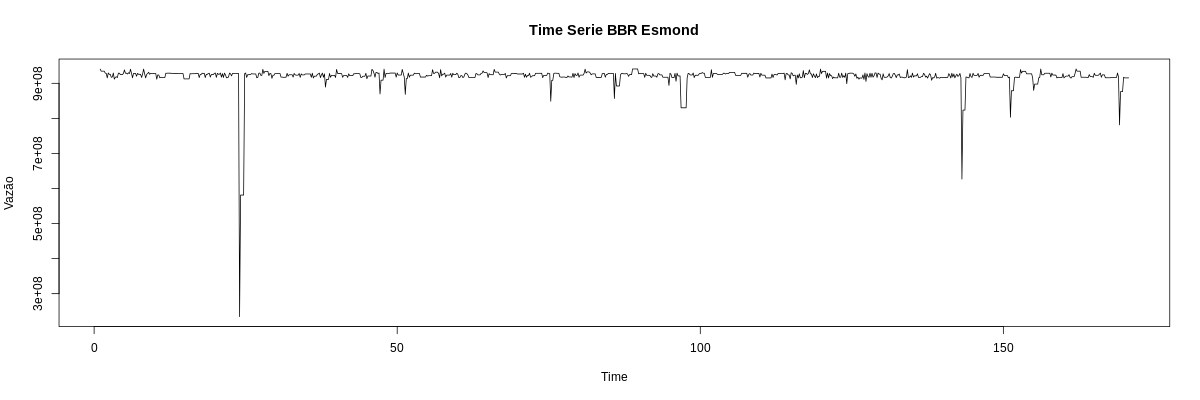

In [ ]:
%%R -i TS -h 400 -w 1200

TS_R = TS

TSbbr = ts(TS_R[,2], start = c(1, 1), frequency = 6)

plot(TSbbr, main = "Time Serie BBR Esmond", ylab = "Vazão")

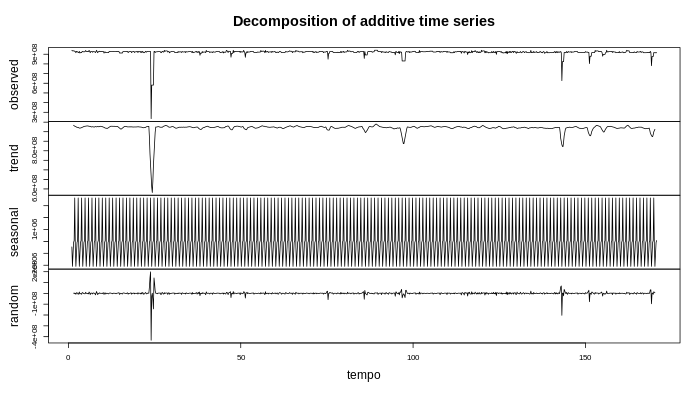

In [ ]:
%%R -w 700 -h 400 # Decomposição da Série (Observação de tendencia e sazonaliadade)

tsdecomp = decompose(TSbbr)

plot(tsdecomp, xlab="tempo", ylab="tendência")

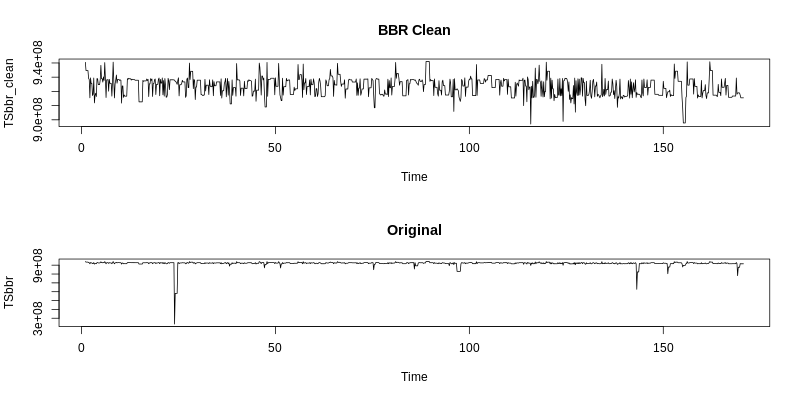

In [ ]:
%%R -h 400 -w 800

# Ajuste inicial da série

TSbbr_clean = tsclean(TSbbr)

par(mfrow = c(2,1))
plot(TSbbr_clean, main = "BBR Clean")
plot(TSbbr, main = "Original")    

### Teste de Estacionariedade (Serie Total - Observação)


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.0725 


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 1.9025 


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.0086 



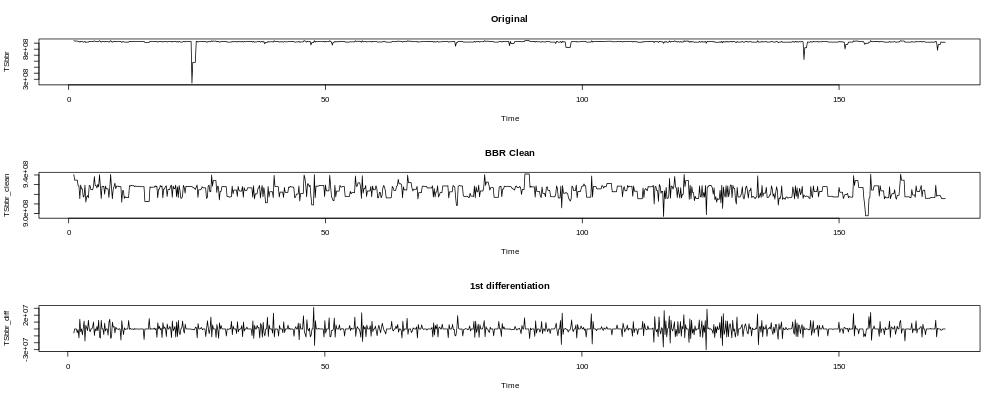

In [ ]:
%%R -h 400 -w 1000 # uma diferenciação

TSbbr_diff <- diff(TSbbr_clean)

par(mfrow = c(3,1))
plot(TSbbr, main = "Original")
plot(TSbbr_clean, main = "BBR Clean")
plot(TSbbr_diff, main = "1st differentiation")

print(ur.kpss(TSbbr))
print(ur.kpss(TSbbr_clean))
print(ur.kpss(TSbbr_diff))

### Separar Conjuntos

In [ ]:
%%R # Separar conjuntos de treino e teste (8 pra 1)

conjunto_treino = c("mytsTrain8",
                    "mytsTrain16",
                    "mytsTrain24",
                    "mytsTrain32",
                    "mytsTrain40",
                    "mytsTrain48",
                    "mytsTrain56",
                    "mytsTrain64",
                    "mytsTrain72",
                    "mytsTrain80",
                    "mytsTrain88",
                    "mytsTrain96",
                    "mytsTrain104",
                    "mytsTrain112",
                    "mytsTrain120",
                    "mytsTrain128",
                    "mytsTrain136",
                    "mytsTrain144",
                    "mytsTrain152",
                    "mytsTrain160",
                    "mytsTrain165")

mytsTrain8 = window(TSbbr_clean, start = c(1,1), end = c(8,6))
mytsTrain16 = window(TSbbr_clean, start = c(1,1), end = c(16,7))
mytsTrain24 = window(TSbbr_clean, start = c(1,1), end = c(24,7))
mytsTrain32 = window(TSbbr_clean, start = c(1,1), end = c(32,7))
mytsTrain40 = window(TSbbr_clean, start = c(1,1), end = c(40,7))
mytsTrain48 = window(TSbbr_clean, start = c(1,1), end = c(48,7))
mytsTrain56 = window(TSbbr_clean, start = c(1,1), end = c(56,7))
mytsTrain64 = window(TSbbr_clean, start = c(1,1), end = c(64,7))
mytsTrain72 = window(TSbbr_clean, start = c(1,1), end = c(72,7))
mytsTrain80 = window(TSbbr_clean, start = c(1,1), end = c(80,7))
mytsTrain88 = window(TSbbr_clean, start = c(1,1), end = c(88,7))
mytsTrain96 = window(TSbbr_clean, start = c(1,1), end = c(96,7))
mytsTrain104 = window(TSbbr_clean, start = c(1,1), end = c(104,7))
mytsTrain112 = window(TSbbr_clean, start = c(1,1), end = c(112,7))
mytsTrain120 = window(TSbbr_clean, start = c(1,1), end = c(120,7))
mytsTrain128 = window(TSbbr_clean, start = c(1,1), end = c(128,7))
mytsTrain136 = window(TSbbr_clean, start = c(1,1), end = c(136,7))
mytsTrain144 = window(TSbbr_clean, start = c(1,1), end = c(144,7))
mytsTrain152 = window(TSbbr_clean, start = c(1,1), end = c(152,7))
mytsTrain160 = window(TSbbr_clean, start = c(1,1), end = c(160,7))
mytsTrain165 = window(TSbbr_clean, start = c(1,1), end = c(165,7))


mytsTest1 = window(TSbbr_clean, start = c(9,1), end = c(9,7))
mytsTest2 = window(TSbbr_clean, start = c(17,1), end = c(17,7))
mytsTest3 = window(TSbbr_clean, start = c(25,1), end = c(25,7))
mytsTest4 = window(TSbbr_clean, start = c(33,1), end = c(33,7))
mytsTest5 = window(TSbbr_clean, start = c(41,1), end = c(41,7))
mytsTest6 = window(TSbbr_clean, start = c(49,1), end = c(49,7))
mytsTest7 = window(TSbbr_clean, start = c(57,1), end = c(57,7))
mytsTest8 = window(TSbbr_clean, start = c(65,1), end = c(65,7))
mytsTest9 = window(TSbbr_clean, start = c(73,1), end = c(73,7))
mytsTest10 = window(TSbbr_clean, start = c(81,1), end = c(81,7))
mytsTest11 = window(TSbbr_clean, start = c(89,1), end = c(89,7))
mytsTest12 = window(TSbbr_clean, start = c(97,1), end = c(97,7))
mytsTest13 = window(TSbbr_clean, start = c(105,1), end = c(105,7))
mytsTest14 = window(TSbbr_clean, start = c(113,1), end = c(113,7))
mytsTest15 = window(TSbbr_clean, start = c(121,1), end = c(121,7))
mytsTest16 = window(TSbbr_clean, start = c(129,1), end = c(129,7))
mytsTest17 = window(TSbbr_clean, start = c(137,1), end = c(137,7))
mytsTest18 = window(TSbbr_clean, start = c(145,1), end = c(145,7))
mytsTest19 = window(TSbbr_clean, start = c(153,1), end = c(153,7))
mytsTest20 = window(TSbbr_clean, start = c(161,1), end = c(161,7))
mytsTest21 = window(TSbbr_clean, start = c(165,1), end = c(166,7))

### Teste de Estacionariedade (PRA)

In [ ]:
%%R # Testes de Estacionariedade (PRA)

adf_test = conjunto_treino = c(
  adf.test(mytsTrain8)$statistic,
  adf.test(mytsTrain16)$statistic,
  adf.test(mytsTrain24)$statistic,
  adf.test(mytsTrain32)$statistic,
  adf.test(mytsTrain40)$statistic,
  adf.test(mytsTrain48)$statistic,
  adf.test(mytsTrain56)$statistic,
  adf.test(mytsTrain64)$statistic,
  adf.test(mytsTrain72)$statistic,
  adf.test(mytsTrain80)$statistic,
  adf.test(mytsTrain88)$statistic,
  adf.test(mytsTrain96)$statistic,
  adf.test(mytsTrain104)$statistic,
  adf.test(mytsTrain112)$statistic,
  adf.test(mytsTrain120)$statistic,
  adf.test(mytsTrain128)$statistic,
  adf.test(mytsTrain136)$statistic,
  adf.test(mytsTrain144)$statistic,
  adf.test(mytsTrain152)$statistic,
  adf.test(mytsTrain160)$statistic,
  adf.test(mytsTrain165)$statistic
)

In [ ]:
%%R 
  adf_test_pvalue <- conjunto_treino <- c(
  adf.test(mytsTrain8)$p.value,
  adf.test(mytsTrain16)$p.value,
  adf.test(mytsTrain24)$p.value,
  adf.test(mytsTrain32)$p.value,
  adf.test(mytsTrain40)$p.value,
  adf.test(mytsTrain48)$p.value,
  adf.test(mytsTrain56)$p.value,
  adf.test(mytsTrain64)$p.value,
  adf.test(mytsTrain72)$p.value,
  adf.test(mytsTrain80)$p.value,
  adf.test(mytsTrain88)$p.value,
  adf.test(mytsTrain96)$sp.value,
  adf.test(mytsTrain104)$p.value,
  adf.test(mytsTrain112)$p.value,
  adf.test(mytsTrain120)$p.value,
  adf.test(mytsTrain128)$p.value,
  adf.test(mytsTrain136)$p.value,
  adf.test(mytsTrain144)$p.value,
  adf.test(mytsTrain152)$p.value,
  adf.test(mytsTrain160)$p.value,
  adf.test(mytsTrain165)$p.value
)

In [ ]:
%%R
  kpss_test = conjunto_treino = c(
  kpss.test(mytsTrain8)$statistic,
  kpss.test(mytsTrain16)$statistic,
  kpss.test(mytsTrain24)$statistic,
  kpss.test(mytsTrain32)$statistic,
  kpss.test(mytsTrain40)$statistic,
  kpss.test(mytsTrain48)$statistic,
  kpss.test(mytsTrain56)$statistic,
  kpss.test(mytsTrain64)$statistic,
  kpss.test(mytsTrain72)$statistic,
  kpss.test(mytsTrain80)$statistic,
  kpss.test(mytsTrain88)$statistic,
  kpss.test(mytsTrain96)$statistic,
  kpss.test(mytsTrain104)$statistic,
  kpss.test(mytsTrain112)$statistic,
  kpss.test(mytsTrain120)$statistic,
  kpss.test(mytsTrain128)$statistic,
  kpss.test(mytsTrain136)$statistic,
  kpss.test(mytsTrain144)$statistic,
  kpss.test(mytsTrain152)$statistic,
  kpss.test(mytsTrain160)$statistic,
  kpss.test(mytsTrain165)$statistic
)

In [ ]:
%%R
  kpss_test_pvalue = conjunto_treino = c(
  kpss.test(mytsTrain8)$p.value,
  kpss.test(mytsTrain16)$p.value,
  kpss.test(mytsTrain24)$p.value,
  kpss.test(mytsTrain32)$p.value,
  kpss.test(mytsTrain40)$p.value,
  kpss.test(mytsTrain48)$p.value,
  kpss.test(mytsTrain56)$p.value,
  kpss.test(mytsTrain64)$p.value,
  kpss.test(mytsTrain72)$p.value,
  kpss.test(mytsTrain80)$p.value,
  kpss.test(mytsTrain88)$p.value,
  kpss.test(mytsTrain96)$p.value,
  kpss.test(mytsTrain104)$p.value,
  kpss.test(mytsTrain112)$p.value,
  kpss.test(mytsTrain120)$p.value,
  kpss.test(mytsTrain128)$p.value,
  kpss.test(mytsTrain136)$p.value,
  kpss.test(mytsTrain144)$p.value,
  kpss.test(mytsTrain152)$p.value,
  kpss.test(mytsTrain160)$p.value,
  kpss.test(mytsTrain165)$p.value
)

In [ ]:
%%R

print(length(conjunto_treino))
print(length(adf_test))
print(length(adf_test_pvalue))
print(length(kpss_test))
print(length(kpss_test_pvalue))

[1] 21
[1] 21
[1] 20
[1] 21
[1] 21


In [ ]:
%%R

testes_estac = data.frame(conjuntos_de_treino = conjunto_treino,
                          ADF_Test = adf_test, #ADF_Pvalue = adf_test_pvalue,
                          KPSS_Test = kpss_test, KPSS_Pvalue = kpss_test_pvalue)

testes_estac

   conjuntos_de_treino   ADF_Test  KPSS_Test KPSS_Pvalue
1            0.1000000  -2.740190 0.13474886   0.1000000
2            0.1000000  -3.318131 0.20404653   0.1000000
3            0.1000000  -4.378143 0.13079311   0.1000000
4            0.1000000  -5.597200 0.11020060   0.1000000
5            0.1000000  -5.874890 0.27239405   0.1000000
6            0.1000000  -6.555040 0.27984689   0.1000000
7            0.1000000  -7.306337 0.24425940   0.1000000
8            0.1000000  -7.592651 0.25500427   0.1000000
9            0.1000000  -7.742700 0.15614443   0.1000000
10           0.1000000  -7.763527 0.22987761   0.1000000
11           0.1000000  -8.171333 0.11194648   0.1000000
12           0.1000000  -8.023819 0.10987432   0.1000000
13           0.1000000  -8.151934 0.10197356   0.1000000
14           0.1000000  -8.474297 0.09361056   0.1000000
15           0.1000000  -9.009638 0.08524132   0.1000000
16           0.1000000  -8.636129 0.27717980   0.1000000
17           0.0212454  -8.7898

‎Caso 1: Ambos os testes concluem que a série não está estacionária - A série não está parada‎

‎Caso 2: Ambos os testes concluem que a série está parada - A série está parada‎

‎Caso 3: KPSS indica estacionária e ADF indica não-estacionária - A série é tendência estacionária. A tendência precisa ser removida para tornar a série estacionária. A série de tendência é verificada para estacionazalidade.‎

‎Caso 4: KPSS indica não-estacionária e ADF indica estacionária - A série é uma diferença estacionária. O diferenciamento deve ser usado para tornar a série estacionária. A série diferenciada é verificada para estacionaza.‎

### Aplicação dos modelos de predição

### Treinamento - (ARIMA, Rede Neural, Holt-Winters)

In [ ]:
%%R # Treinamento ARIMA

mytsArima8 = auto.arima(mytsTrain8, d=1, lambda = 0)
mytsArima16 = auto.arima(mytsTrain16, d=1, lambda = 0)
mytsArima24 = auto.arima(mytsTrain24, d=1, lambda = 0)
mytsArima32 = auto.arima(mytsTrain32, d=1, lambda = 0)
mytsArima40 = auto.arima(mytsTrain40, d=1, lambda = 0)
mytsArima48 = auto.arima(mytsTrain48, d=1, lambda = 0)
mytsArima56 = auto.arima(mytsTrain56, d=1, lambda = 0)
mytsArima64 = auto.arima(mytsTrain64, d=1, lambda = 0)
mytsArima72 = auto.arima(mytsTrain72, d=1, lambda = 0)
mytsArima80 = auto.arima(mytsTrain80, d=1, lambda = 0)
mytsArima88 = auto.arima(mytsTrain88, d=1, lambda = 0)
mytsArima96 = auto.arima(mytsTrain96, d=1, lambda = 0)
mytsArima104 = auto.arima(mytsTrain104, d=1, lambda = 0)
mytsArima112 = auto.arima(mytsTrain112, d=1, lambda = 0)
mytsArima120 = auto.arima(mytsTrain120, d=1, lambda = 0)
mytsArima128 = auto.arima(mytsTrain128, d=1, lambda = 0)
mytsArima136 = auto.arima(mytsTrain136, d=1, lambda = 0)
mytsArima144 = auto.arima(mytsTrain144, d=1, lambda = 0)
mytsArima152 = auto.arima(mytsTrain152, d=1, lambda = 0)
mytsArima160 = auto.arima(mytsTrain160, d=1, lambda = 0)
mytsArima165 = auto.arima(mytsTrain165, d=1, lambda = 0)

In [ ]:
%%R # Treinamento Neural

mytsNeural8 = nnetar(mytsTrain8, d=1, lambda = 0)
mytsNeural16 = nnetar(mytsTrain16, d=1, lambda = 0)
mytsNeural24 = nnetar(mytsTrain24, d=1, lambda = 0)
mytsNeural32 = nnetar(mytsTrain32, d=1, lambda = 0)
mytsNeural40 = nnetar(mytsTrain40, d=1, lambda = 0)
mytsNeural48 = nnetar(mytsTrain48, d=1, lambda = 0)
mytsNeural56 = nnetar(mytsTrain56, d=1, lambda = 0)
mytsNeural64 = nnetar(mytsTrain64, d=1, lambda = 0)
mytsNeural72 = nnetar(mytsTrain72, d=1, lambda = 0)
mytsNeural80 = nnetar(mytsTrain80, d=1, lambda = 0)
mytsNeural88 = nnetar(mytsTrain88, d=1, lambda = 0)
mytsNeural96 = nnetar(mytsTrain96, d=1, lambda = 0)
mytsNeural104 = nnetar(mytsTrain104, d=1, lambda = 0)
mytsNeural112 = nnetar(mytsTrain112, d=1, lambda = 0)
mytsNeural120 = nnetar(mytsTrain120, d=1, lambda = 0)
mytsNeural128 = nnetar(mytsTrain128, d=1, lambda = 0)
mytsNeural136 = nnetar(mytsTrain136, d=1, lambda = 0)
mytsNeural144 = nnetar(mytsTrain144, d=1, lambda = 0)
mytsNeural152 = nnetar(mytsTrain152, d=1, lambda = 0)
mytsNeural160 = nnetar(mytsTrain160, d=1, lambda = 0)
mytsNeural165 = nnetar(mytsTrain165, d=1, lambda = 0)



In [ ]:
%%R # Treinamento Holt-Winters

mytsHoltETS8 = ets(mytsTrain8, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS16 = ets(mytsTrain16, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS24 = ets(mytsTrain24, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS32 = ets(mytsTrain32, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS40 = ets(mytsTrain40, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS48 = ets(mytsTrain48, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS56 = ets(mytsTrain56, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS64 = ets(mytsTrain64, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS72 = ets(mytsTrain72, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS80 = ets(mytsTrain80, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS88 = ets(mytsTrain88, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS96 = ets(mytsTrain96, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS104 = ets(mytsTrain104, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS112 = ets(mytsTrain112, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS120 = ets(mytsTrain120, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS128 = ets(mytsTrain128, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS136 = ets(mytsTrain136, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS144 = ets(mytsTrain144, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS152 = ets(mytsTrain152, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS160 = ets(mytsTrain160, model = 'ZAA', damped = T, lambda = 0)
mytsHoltETS165 = ets(mytsTrain165, model = 'ZAA', damped = T, lambda = 0)

### Previsões

In [ ]:
%%R # Previsão ARIMA

prevArima8 = forecast(mytsArima8, h=6)
prevArima16 = forecast(mytsArima16, h=6)
prevArima24 = forecast(mytsArima24, h=6)
prevArima32 = forecast(mytsArima32, h=6)
prevArima40 = forecast(mytsArima40, h=6)
prevArima48 = forecast(mytsArima48, h=6)
prevArima56 = forecast(mytsArima56, h=6)
prevArima64 = forecast(mytsArima64, h=6)
prevArima72 = forecast(mytsArima72, h=6)
prevArima80 = forecast(mytsArima80, h=6)
prevArima88 = forecast(mytsArima88, h=6)
prevArima96 = forecast(mytsArima96, h=6)
prevArima104 = forecast(mytsArima104, h=6)
prevArima112 = forecast(mytsArima112, h=6)
prevArima120 = forecast(mytsArima120, h=6)
prevArima128 = forecast(mytsArima128, h=6)
prevArima136 = forecast(mytsArima136, h=6)
prevArima144 = forecast(mytsArima144, h=6)
prevArima152 = forecast(mytsArima152, h=6)
prevArima160 = forecast(mytsArima160, h=6)
prevArima165 = forecast(mytsArima165, h=6)

prevArima144

         Point Forecast     Lo 80     Hi 80     Lo 95     Hi 95
145.1667      921226739 914003099 928507469 910202092 932384919
145.3333      922867118 915424705 930370038 911509256 934366505
145.5000      920299378 912644893 928018063 908618658 932130259
145.6667      920521199 912813453 928294029 908759378 932435250
145.8333      920991009 913277590 928769574 909220537 932913857
146.0000      920237247 912528404 928011213 908473764 932153051


In [ ]:
%%R # Previsão com Rede Neural

prevNeural8 = forecast(mytsNeural8, h=6)
prevNeural16 = forecast(mytsNeural16, h=6)
prevNeural24 = forecast(mytsNeural24, h=6)
prevNeural32 = forecast(mytsNeural32, h=6)
prevNeural40 = forecast(mytsNeural40, h=6)
prevNeural48 = forecast(mytsNeural48, h=6)
prevNeural56 = forecast(mytsNeural56, h=6)
prevNeural64 = forecast(mytsNeural64, h=6)
prevNeural72 = forecast(mytsNeural72, h=6)
prevNeural80 = forecast(mytsNeural80, h=6)
prevNeural88 = forecast(mytsNeural88, h=6)
prevNeural96 = forecast(mytsNeural96, h=6)
prevNeural104 = forecast(mytsNeural104, h=6)
prevNeural112 = forecast(mytsNeural112, h=6)
prevNeural120 = forecast(mytsNeural120, h=6)
prevNeural128 = forecast(mytsNeural128, h=6)
prevNeural136 = forecast(mytsNeural136, h=6)
prevNeural144 = forecast(mytsNeural144, h=6)
prevNeural152 = forecast(mytsNeural152, h=6)
prevNeural160 = forecast(mytsNeural160, h=6) 
prevNeural165 = forecast(mytsNeural165, h=6)

In [ ]:
%%R # Previsões Holt-Winters

prevHolt8 = forecast(mytsHoltETS8, h=6)
prevHolt16 = forecast(mytsHoltETS16, h=6)
prevHolt24 = forecast(mytsHoltETS24, h=6)
prevHolt32 = forecast(mytsHoltETS32, h=6)
prevHolt40 = forecast(mytsHoltETS40, h=6)
prevHolt48 = forecast(mytsHoltETS48, h=6)
prevHolt56 = forecast(mytsHoltETS56, h=6)
prevHolt64 = forecast(mytsHoltETS64, h=6)
prevHolt72 = forecast(mytsHoltETS72, h=6)
prevHolt80 = forecast(mytsHoltETS80, h=6)
prevHolt88 = forecast(mytsHoltETS88, h=6)
prevHolt96 = forecast(mytsHoltETS96, h=6)
prevHolt104 = forecast(mytsHoltETS104, h=6)
prevHolt112 = forecast(mytsHoltETS112, h=6)
prevHolt120 = forecast(mytsHoltETS120, h=6)
prevHolt128 = forecast(mytsHoltETS128, h=6)
prevHolt136 = forecast(mytsHoltETS136, h=6)
prevHolt144 = forecast(mytsHoltETS144, h=6)
prevHolt152 = forecast(mytsHoltETS152, h=6)
prevHolt160 = forecast(mytsHoltETS160, h=6)
prevHolt165 = forecast(mytsHoltETS165, h=6)

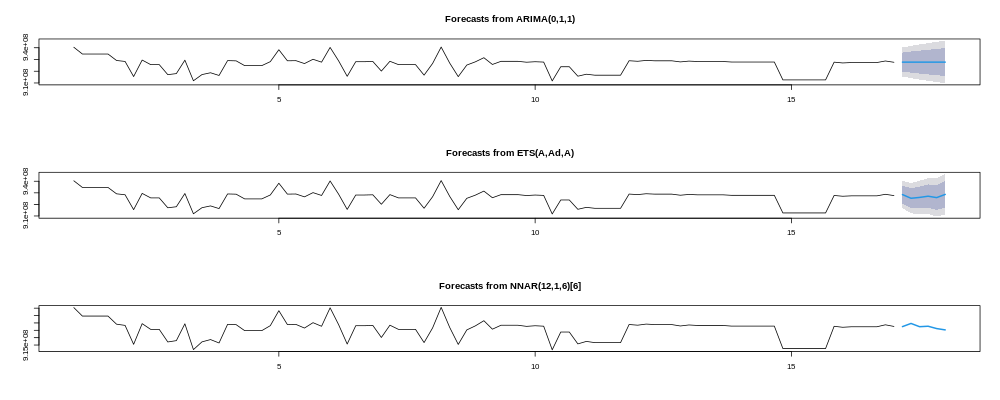

In [ ]:
%%R -w 1000 -h 400

par(mfrow = c(3,1))
plot(prevArima16)
plot(prevHolt16)
plot(prevNeural16)

### Plots - Comparação de alguns ciclos

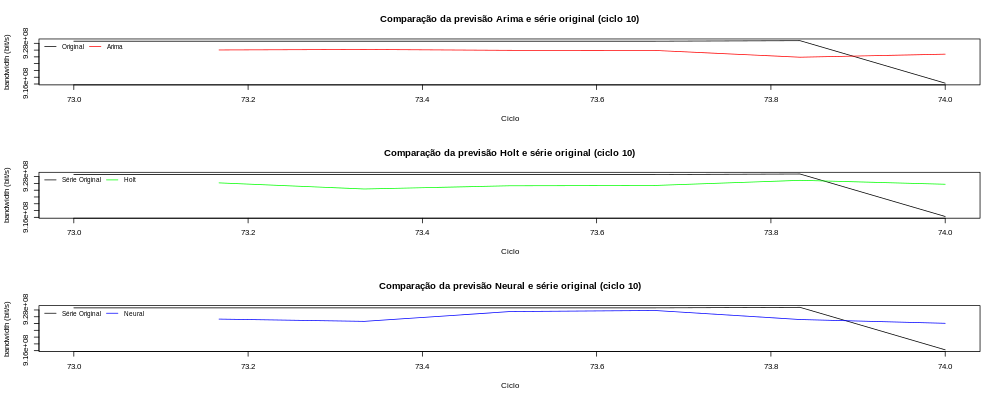

In [ ]:
%%R -h 400 -w 1000 # ciclo 10

par(mfrow = c(3, 1))
plot(mytsTest9, main="Comparação da previsão Arima e série original (ciclo 10)", xlab="Ciclo", ylab="bandwidth (bit/s)")
lines(prevArima72$mean, col="red")
legend("topleft", legend = c("Original", "Arima"), col = c("black", "red"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest9, main="Comparação da previsão Holt e série original (ciclo 10)", xlab="Ciclo", ylab="bandwidth (bit/s)")
lines(prevHolt72$mean, col="green")
legend("topleft", legend = c("Série Original", "Holt"), col = c("black", "green"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest9, main="Comparação da previsão Neural e série original (ciclo 10)", xlab="Ciclo", ylab="bandwidth (bit/s)")
lines(prevNeural72$mean, col="blue")
legend("topleft", legend = c("Série Original", "Neural"), col = c("black", "blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

#dev.off()

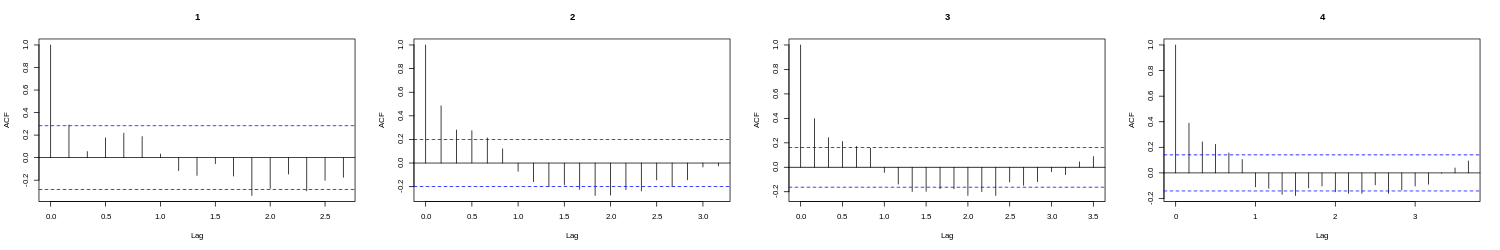

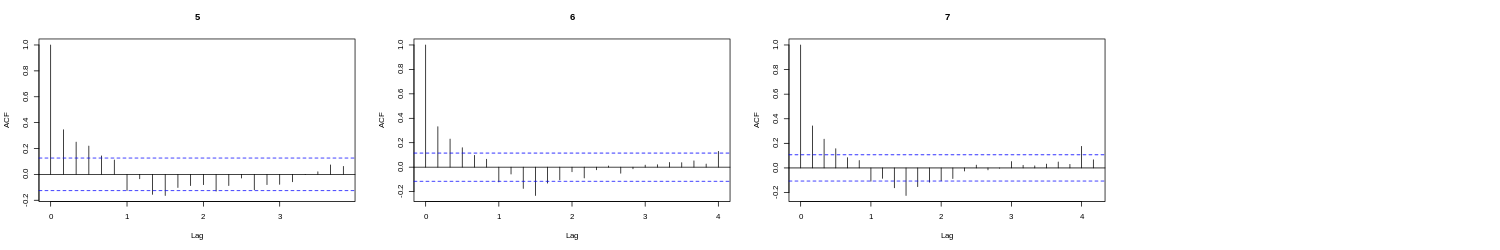

In [ ]:
%%R -h 250 -w 1500 # Autocorrelação dos conjuntos de treinamento (Indica dados estacionários)

par(mfrow = c(1, 4))
acf(mytsTrain8, main = "1")
acf(mytsTrain16, main = "2")
acf(mytsTrain24, main = "3")
acf(mytsTrain32, main = "4")
acf(mytsTrain40, main = "5")
acf(mytsTrain48, main = "6")
acf(mytsTrain56, main = "7")


## Avaliação

### RMSE

In [ ]:
%%R

Neural_RMSE_inOrder = c(
  rmse(mytsTest1, prevNeural8$mean),
  rmse(mytsTest2, prevNeural16$mean),
  rmse(mytsTest3, prevNeural24$mean),
  rmse(mytsTest4, prevNeural32$mean),
  rmse(mytsTest5, prevNeural40$mean),
  rmse(mytsTest6, prevNeural48$mean),
  rmse(mytsTest7, prevNeural56$mean),
  rmse(mytsTest8, prevNeural64$mean),
  rmse(mytsTest9, prevNeural72$mean),
  rmse(mytsTest10, prevNeural80$mean),
  rmse(mytsTest12, prevNeural88$mean),
  rmse(mytsTest13, prevNeural96$mean),
  rmse(mytsTest14, prevNeural104$mean),
  rmse(mytsTest13, prevNeural96$mean),
  rmse(mytsTest13, prevNeural96$mean),
  rmse(mytsTest13, prevNeural96$mean),
  rmse(mytsTest13, prevNeural96$mean),
  rmse(mytsTest13, prevNeural96$mean)
)

print(Neural_RMSE_inOrder)

 [1] 3384549 5810221 5032589 4836490 5285070 6551622 9700133 6389730 4137950
[10] 2769226     NaN     NaN     NaN


In [ ]:
%%R

Holt_RMSE_inOrder = c(
  rmse(mytsTest1, prevHolt8$mean),
  rmse(mytsTest2, prevHolt16$mean),
  rmse(mytsTest3, prevHolt24$mean),
  rmse(mytsTest4, prevHolt32$mean),
  rmse(mytsTest5, prevHolt40$mean),
  rmse(mytsTest6, prevHolt48$mean),
  rmse(mytsTest7, prevHolt56$mean),
  rmse(mytsTest6, prevHolt48$mean),
  rmse(mytsTest6, prevHolt48$mean),
  rmse(mytsTest6, prevHolt48$mean),
  rmse(mytsTest6, prevHolt48$mean),
  rmse(mytsTest6, prevHolt48$mean),
  rmse(mytsTest6, prevHolt48$mean)
)

print(Holt_RMSE_inOrder)

[1] 3684798 3967697 4600373 3766512 2944987 4897459 7177856


In [ ]:
%%R 

Arima_RMSE_inOrder = c(
  rmse(mytsTest1, prevArima8$mean),
  rmse(mytsTest2, prevArima16$mean),
  rmse(mytsTest3, prevArima24$mean),
  rmse(mytsTest4, prevArima32$mean),
  rmse(mytsTest5, prevArima40$mean),
  rmse(mytsTest6, prevArima48$mean),
  rmse(mytsTest7, prevArima56$mean)
)

print(Arima_RMSE_inOrder)

[1] 3154607 4902185 5096048 2936743 3059044 5334759 8664024


### MAPE

In [ ]:
%%R

Arima_MAPE_inOrder = c(
  mape(mytsTest1, prevArima8$mean),
  mape(mytsTest2, prevArima16$mean),
  mape(mytsTest3, prevArima24$mean),
  mape(mytsTest4, prevArima32$mean),
  mape(mytsTest5, prevArima40$mean),
  mape(mytsTest6, prevArima48$mean),
  mape(mytsTest7, prevArima56$mean)
)

print(Arima_MAPE_inOrder)

[1] 0.002866033 0.003314726 0.004116278 0.002141491 0.002064933 0.004627977
[7] 0.007024723


In [ ]:
%%R

Neural_MAPE_inOrder = c(
  mape(mytsTest1, prevNeural8$mean)*100,
  mape(mytsTest2, prevNeural16$mean)*100,
  mape(mytsTest3, prevNeural24$mean)*100,
  mape(mytsTest4, prevNeural32$mean)*100,
  mape(mytsTest5, prevNeural40$mean)*100,
  mape(mytsTest6, prevNeural48$mean)*100,
  mape(mytsTest7, prevNeural56$mean)*100
)

print(Neural_MAPE_inOrder)

[1] 0.3155729 0.4372514 0.4860427 0.3607149 0.4683828 0.6294387 0.7857149


In [ ]:
%%R

Holt_MAPE_inOrder = c(
  mape(mytsTest1, prevHolt5$mean)*100,
  mape(mytsTest2, prevHolt10$mean)*100,
  mape(mytsTest3, prevHolt15$mean)*100,
  mape(mytsTest4, prevHolt20$mean)*100,
  mape(mytsTest5, prevHolt25$mean)*100,
  mape(mytsTest6, prevHolt30$mean)*100,
  mape(mytsTest7, prevHolt35$mean)*100
)

print(Holt_MAPE_inOrder)